In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('"./Bitcoin_tweets.csv"'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
from scipy import stats as stat

In [4]:
df_path = "./Bitcoin_tweets.csv"
df = pd.read_csv(df_path)

c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (1,2,3,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.drop(["user_name","user_description", "user_created","user_location"], axis=1, inplace=True)
df.drop(df.loc[df.user_verified.isna()].index, axis=0, inplace=True)

In [6]:
df["hashtags"]=df["hashtags"].apply(lambda s : s[1:-1].split(',') if isinstance(s,str) else [])
df["hashtags_len"]=df["hashtags"].apply(len)

In [7]:
def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)
df["user_followers"]=df["user_followers"].apply(lambda x : conv_to_int(x))
df["user_friends"]=df["user_friends"].apply(lambda x : conv_to_int(x))
df["user_favourites"]=df["user_favourites"].apply(lambda x : conv_to_int(x))

In [8]:
def clean_text(text):
    if(isinstance(text, str)):
        text = text.replace("#","")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""

df["clean_text"]=df["text"].apply(clean_text)
df.drop("text", axis=1, inplace=True)

In [9]:
df["date"]=pd.to_datetime(df["date"],errors='coerce')
df["date"]=df["date"].apply(lambda x: x.date() )

In [10]:
def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

In [11]:
df["impact_score"]=df.apply(generate_impact_score, axis=1)

In [12]:
import yfinance as yf
btc_stock=yf.Ticker("BTC-USD")

In [13]:
start = min(df['date'])
end = max(df['date'])
btc_stock = btc_stock.history(start=start, end=end)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  """Entry point for launching an IPython kernel.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  


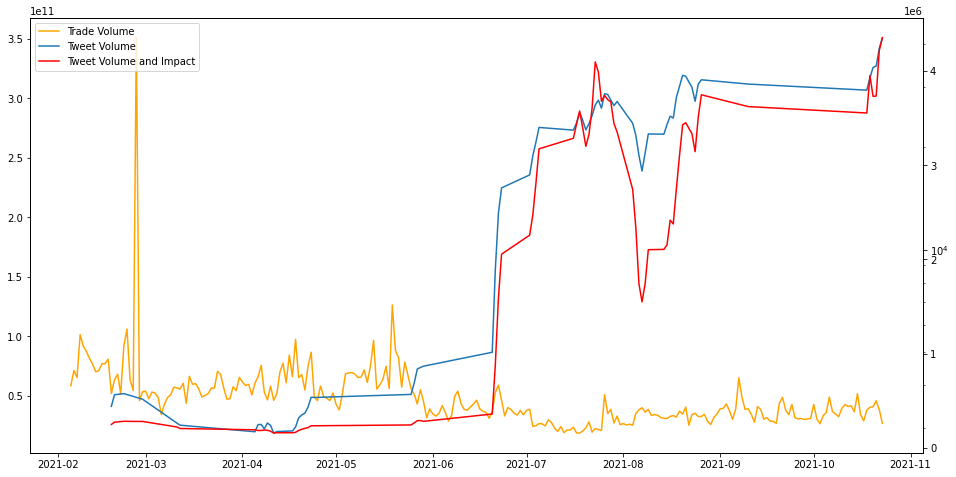

Spearman correlation - tweets: corr=-0.6228537844758827 pval=3.2286976364688837e-10
Spearman correlation - impact tweets: corr=-0.6656941354267243 pval=6.594370716703912e-12


In [14]:
tweet_shift1 = df.groupby('date').size().shift(-1).dropna() 
tweet_shift1_impact = df.groupby('date')["impact_score"].sum().shift(-1).dropna() 

stocks_data = btc_stock['Volume'].dropna()

corr, pval = stat.spearmanr(tweet_shift1.reindex(stocks_data.index), stocks_data,nan_policy='omit')
corr_i, pval_i = stat.spearmanr(tweet_shift1_impact.reindex(stocks_data.index), stocks_data,nan_policy='omit')

tweets_vol = df.groupby('date').size().rolling(10).mean().dropna()
tweets_vol_impact= df.groupby('date')["impact_score"].sum().rolling(10).mean().dropna()

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(stocks_data.index,stocks_data,color='orange',label='Trade Volume')
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2.plot(tweets_vol.index,tweets_vol,label='Tweet Volume')
ax2.set_yscale('log')
ax2.tick_params(axis='y')

ax3=ax.twinx()
ax3.plot(tweets_vol_impact.index,tweets_vol_impact,label='Tweet Volume and Impact', color='red')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)

plt.show()

print("Spearman correlation - tweets: corr={} pval={}".format(corr,pval))
print("Spearman correlation - impact tweets: corr={} pval={}".format(corr_i,pval_i))

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer

def get_polarity_score(tweet):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(tweet)["compound"]
    
def get_polarity_cat(score):
    if score >=0.05 : 
        return "positive"
    elif score <=-0.05:
        return "negative"
    else:
        return "neutral"

df["polarity_score"]=df["clean_text"].apply(get_polarity_score)
df["polarity_cat"]=df["polarity_score"].apply(get_polarity_cat)

In [16]:
df.head()

,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_retweet,hashtags_len,clean_text,impact_score,polarity_score,polarity_cat
0,8534.0,0.0,0.0,False,2021-02-10,['bitcoin'],Twitter Web App,False,1,Blue Ridge Bank shares halted by NYSE after bi...,98.56770,0.2960,positive
1,6769.0,0.0,0.0,False,2021-02-10,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,4,"😎 Today, that's this Thursday, we will do a ""🎬...",89.35080,0.6808,positive
2,128.0,0.0,0.0,False,2021-02-10,[],Twitter Web App,False,0,"Guys evening, I have read this article about B...",1.40800,0.5719,positive
3,625.0,0.0,0.0,False,2021-02-10,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,4,$BTC A big chance in a billion! Price: \487264...,8.25000,0.3164,positive
4,1249.0,0.0,0.0,False,2021-02-10,['BTC'],Twitter Web App,False,1,This network is secured by 9 508 nodes as of t...,14.42595,0.4019,positive


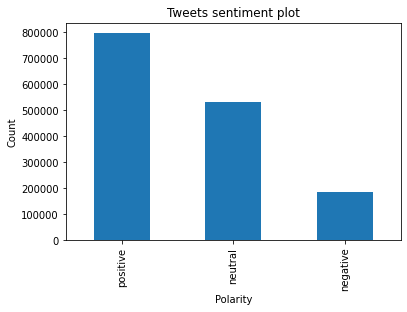

In [17]:
df['polarity_cat'].value_counts().plot(kind="bar")
plt.title("Tweets sentiment plot")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.show()

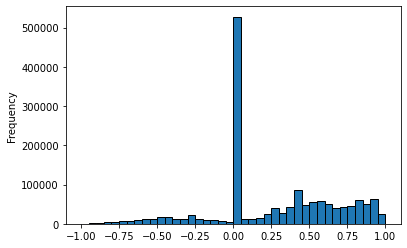

In [18]:
df.polarity_score.plot(kind='hist',range=(-1,1),bins=40,edgecolor='black');

In [19]:
df_positive=df.loc[df.polarity_cat=="positive"]
df_negative=df.loc[df.polarity_cat=="negative"]
df_neutral=df.loc[df.polarity_cat=="neutral"]

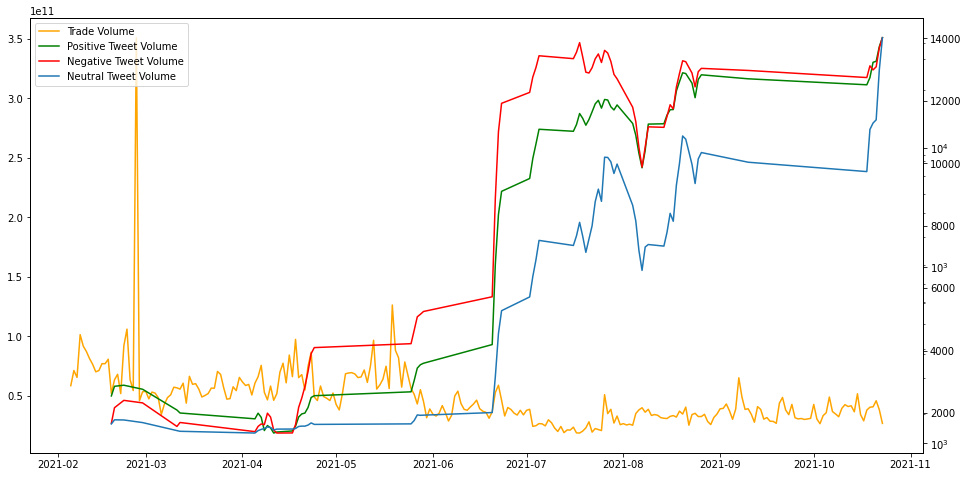

Spearman correlation - tweets: corr=-0.6297804458251123 pval=1.7921223780832605e-10
Spearman correlation - tweets: corr=-0.6371440865982749 pval=9.430206292195501e-11
Spearman correlation - tweets: corr=-0.6276637613104411 pval=2.1486482547396995e-10


In [20]:
tweet_shift_positive = df_positive.groupby('date').size().shift(-1) 
tweet_shift_negative = df_negative.groupby('date').size().shift(-1) 
tweet_shift_neutral = df_neutral.groupby('date').size().shift(-1)

stocks_data = btc_stock['Volume'].dropna()

corr_positive, pval_positive = stat.spearmanr(tweet_shift_positive.reindex(stocks_data.index), stocks_data,nan_policy='omit')
corr_negative, pval_negative = stat.spearmanr(tweet_shift_negative.reindex(stocks_data.index), stocks_data,nan_policy='omit')
corr_neutral, pval_neutral = stat.spearmanr(tweet_shift_neutral.reindex(stocks_data.index), stocks_data,nan_policy='omit')

tweets_vol_positive = df_positive.groupby('date').size().rolling(10).mean()
tweets_vol_negative = df_negative.groupby('date').size().rolling(10).mean()
tweets_vol_neutral = df_neutral.groupby('date').size().rolling(10).mean()

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(stocks_data.index,stocks_data,color='orange',label='Trade Volume')
ax3.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(tweets_vol_positive.index,tweets_vol_positive,label='Positive Tweet Volume', color="green")
ax2.set_yscale('log')
ax2.tick_params(axis='y')

ax3 = ax.twinx()
ax3.plot(tweets_vol_negative.index,tweets_vol_negative,label='Negative Tweet Volume', color="red")
ax3.set_yscale('log')

ax4 = ax.twinx()
ax4.plot(tweets_vol_neutral.index,tweets_vol_neutral,label='Neutral Tweet Volume')
ax4.tick_params(axis='y')
ax3.set_yscale('log')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3 + lines4, labels + labels2 + labels3 + labels4, loc=0)

plt.show()

print("Spearman correlation - tweets: corr={} pval={}".format(corr_positive,pval_positive))
print("Spearman correlation - tweets: corr={} pval={}".format(corr_negative,pval_negative))
print("Spearman correlation - tweets: corr={} pval={}".format(corr_neutral,pval_neutral))

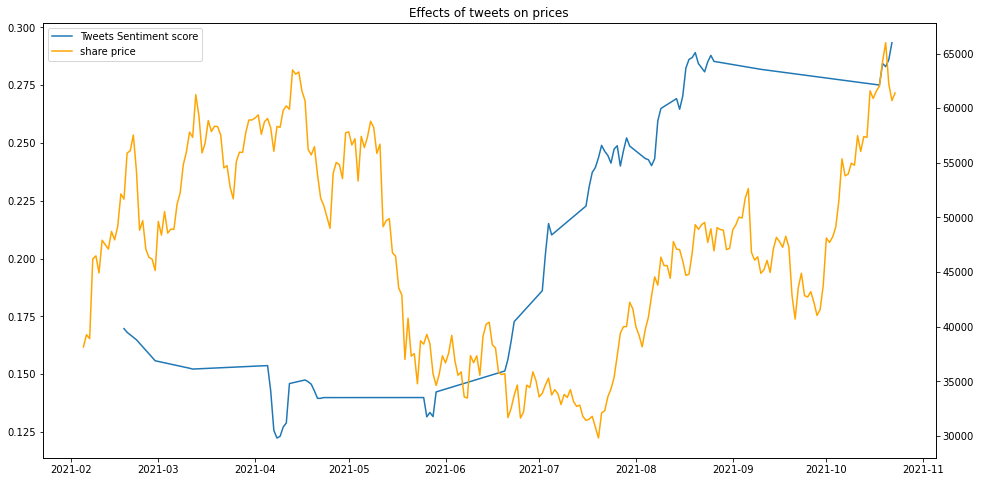

Spearman correlation: corr=-0.21151504974602242 pval=0.05491498433101098


In [21]:
sentiment= df.groupby('date')['polarity_score'].mean().shift(-1).rolling(10).mean()
corr_test = df.groupby('date')['polarity_score'].mean().shift(-1)
corr, pval = stat.spearmanr(corr_test.reindex(btc_stock.index), btc_stock['Open'],nan_policy='omit')

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(sentiment.index,sentiment,label='Tweets Sentiment score')
ax2 = ax.twinx()
ax2.plot(btc_stock.index,btc_stock['Close'],color='orange',label='share price')
ax2.set_title("Effects of tweets on prices")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

print("Spearman correlation: corr={} pval={}".format(corr,pval))